In [425]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

<ipython-input-426-de66bb0fd666>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


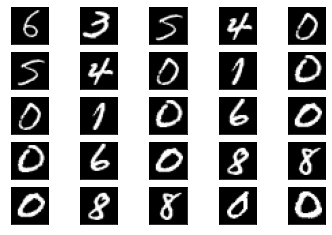

In [426]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

In [427]:
print("x_train:", x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1).T
print("x_train flatten:", x_train.shape)
print("y_train:", y_train.shape)
y_train = y_train.reshape(y_train.shape[0],1).T
print("y_train:", y_train.shape)

x_train: (60000, 28, 28)
x_train flatten: (784, 60000)
y_train: (60000,)
y_train: (1, 60000)


## Code

## Import

In [428]:
import numpy as np

## Normalization

In [429]:
x_train = x_train/255
x_test = x_test/255

## initialize_parameters

In [430]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        print('W'+str(l), ":", parameters['W'+str(l)].shape)
        parameters['b'+str(l)] = np.ones((layers_dims[l], 1))
        print('b'+str(l), ":", parameters['b'+str(l)].shape)
        
    
    return parameters

## activation_funtion

In [431]:
def activation_funtion(Z, activation):
    if activation == "relu":
        print("activation:", activation)
        return np.maximum(np.zeros(1), Z)
        
    if activation == "sigmoid":
        print("activation:", activation)
        return 1 / (1 + np.exp(-Z))
    
    print("activation: linear")
    return Z

## forward_propagation

In [432]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters) // 2
    cache['A0'] = X
    print('A0', ":", X.shape)
    
    for l in range(1,L):
        cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
        print('Z'+str(l), ":", cache['Z'+str(l)].shape)
        cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
        print('A'+str(l), ":", cache['A'+str(l)].shape)
    l += 1
    
    cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
    print('Z'+str(l), ":", cache['Z'+str(l)].shape)
    cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    print('A'+str(l), ":", cache['A'+str(l)].shape)
    
    return cache

## compute_cost

In [433]:
def compute_cost(AL,Y, loss):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        epsilon = 1e-10
        cost = -(1/m) * np.sum(np.multiply(np.log(AL + epsilon), Y) + np.multiply(np.log(1-AL + epsilon), 1-Y))
        return np.squeeze(cost)


In [451]:
def activation_derivative(Z, activation):
    if activation == "relu":
        print(Z.shape)
        dZ = np.ones(Z.shape)
        return (dZ < 0).astype(int)
        
    if activation == "sigmoid":
        return np.multiply(activation_funtion(Z, "sigmoid"), (1- activation_funtion(Z, "sigmoid")))
    
    return Z

## back_propagation

In [479]:
def back_propagation(X, Y, parameters, cache, activation):
    grads = {}
    L = len(parameters) // 2
    m = Y.shape[1]
    
    grads["dZ" + str(L)] = cache['A' + str(L)] - Y
    print("dZ" + str(L), ":", grads["dZ" + str(L)].shape)
    grads["dW" + str(L)] = (1/m) * np.dot(grads["dZ" + str(L)], cache['A' + str(L-1)].T)
    print("dW" + str(L), ":", grads["dW" + str(L)].shape)
    grads["db" + str(L)] = (1/m) * np.sum(grads["dZ" + str(L)], axis= 1, keepdims= True)
    print("db" + str(L), ":", grads["db" + str(L)].shape)
    
    for l in range(L-1,1,-1):
        grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))
        print("dZ" + str(l), ":", grads["dZ" + str(l)].shape)
        grads["dW" + str(l)] = (1/m) * np.dot(cache['A' + str(l-1)], grads["dZ" + str(l)].T)
        print("dW" + str(l), ":", grads["dW" + str(l)].shape)
        grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
        print("db" + str(l), ":", grads["db" + str(l)].shape)
    
    l -= 1
    
    grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))
    print("dZ" + str(l), ":", grads["dZ" + str(l)].shape)
    grads["dW" + str(l)] = (1/m) * np.dot(cache['A' + str(l-1)], grads["dZ" + str(l)].T)
    print("dW" + str(l), ":", grads["dW" + str(l)].shape)
    grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    print("db" + str(l), ":", grads["db" + str(l)].shape)
    
    return grads

In [480]:
layers_dims = [x_train_flatten.shape[0],32,16,10]
activation = ["relu","relu","sigmoid"]
loss_funtion = "cross_entropy"

print(y_train.shape)

parameters = initialize_parameters(layers_dims)

cache = forward_propagation(x_train_flatten, parameters, activation)

cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, y_train, loss_funtion)

print("cost:",cost)

(1, 60000)
W1 : (32, 784)
b1 : (32, 1)
W2 : (16, 32)
b2 : (16, 1)
W3 : (10, 16)
b3 : (10, 1)
A0 : (784, 60000)
Z1 : (32, 60000)
activation: relu
A1 : (32, 60000)
Z2 : (16, 60000)
activation: relu
A2 : (16, 60000)
Z3 : (10, 60000)
activation: sigmoid
A3 : (10, 60000)
cost: 4759.810636928758


In [482]:
layers_dims = [5,5,2,4]
activation = ["relu","relu","sigmoid"]
loss_funtion = "cross_entropy"

X = np.random.randn(layers_dims[0],1) * 10
Y = np.array([[0]])

parameters = initialize_parameters(layers_dims)

cache = forward_propagation(X, parameters, activation)

cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y, loss_funtion)

grads = back_propagation(X, Y, parameters, cache, activation)

print(grads)

W1 : (5, 5)
b1 : (5, 1)
W2 : (2, 5)
b2 : (2, 1)
W3 : (4, 2)
b3 : (4, 1)
A0 : (5, 1)
Z1 : (5, 1)
activation: relu
A1 : (5, 1)
Z2 : (2, 1)
activation: relu
A2 : (2, 1)
Z3 : (4, 1)
activation: sigmoid
A3 : (4, 1)
dZ3 : (4, 1)
dW3 : (4, 2)
db3 : (4, 1)
(2, 1)
dZ2 : (2, 1)
dW2 : (5, 2)
db2 : (2, 1)
(5, 1)
dZ1 : (5, 1)
dW1 : (5, 5)
db1 : (5, 1)
{'dZ3': array([[9.99996616e-01],
       [2.76269459e-04],
       [9.99977939e-01],
       [3.43277310e-11]]), 'dW3': array([[2.09030278e+01, 3.79488464e+00],
       [5.77488773e-03, 1.04841428e-03],
       [2.09026374e+01, 3.79481376e+00],
       [7.17555944e-10, 1.30270220e-10]]), 'db3': array([[9.99996616e-01],
       [2.76269459e-04],
       [9.99977939e-01],
       [3.43277310e-11]]), 'dZ2': array([[ 0.],
       [-0.]]), 'dW2': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'db2': array([[0.],
       [0.]]), 'dZ1': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]]), 'dW1': array([[0., 0., 0., 